# K-Means and Gaussian Mixture Models

## Proposed Method

We will first use the k-means clustering algorithm to produce the mean values that we will use to initialize our GMMs, followed by Expectation Maximization to calculate the covariances of the GMMs.

## Step 0: Data Preparation and Exploration

After importing our basic utility libraries and dataset, we plot our data to get an understanding of what kind of models we should be working with. 

We will first work with the Synthetic data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

train_data = np.loadtxt("Synthetic/29/train.txt",delimiter=",")
train_data_classes = np.asarray([train_data[np.where(train_data[:,2]==i)] for i in [1,2]])

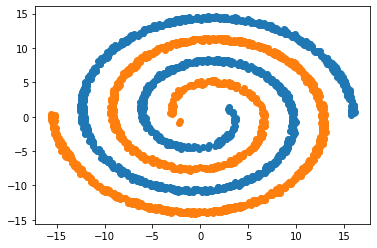

In [2]:
plt.scatter(train_data_classes[0,:,0],train_data_classes[0,:,1])
plt.scatter(train_data_classes[1,:,0],train_data_classes[1,:,1])
plt.show()

As we can clearly see above, using k-means clustering on this dataset with 2 clusters will yield disastrous results.

Hence, we will instead use k-means to initialize our mean positions and then utilize them to generate GMMs.

## Step 1: Implementing $k$-means clustering

This step is slightly complex, so reading through the comments will be more useful to follow along.

We essentially make use of numpy broadcasting and indexing to vectorize our entire operation which speeds it up tremendously. 

Vectorization enables our code to be generalized to work with any $d$ dimensional dataset, with any choice of $k$, and any dataset size $n$. The only thing required is for each data example to be provided in the form `[x1, x2, x3, ... xn, class]`

In [3]:
def k_means(data,k=15):
    # reshape data for numpy broadcasting
    data = np.reshape(data,[-1,1,data.shape[-1]])
    # initialize k means with random means
    myrange = np.linspace(0,data.shape[0]-1,k,dtype = np.int64)
    kmeans = np.vstack([data[myrange,0,i] for i in range(0,data.shape[-1])]).T
    # reshape data for numpy broadcasting
    kmeans = np.reshape(kmeans,[1,-1,kmeans.shape[-1]])
    # calculate distances with some broadcasting magic
    dists = np.sqrt(np.sum((data - kmeans)**2,axis=2))
    # initialize cluster assignments
    
    # choose n rows from a kxk identity matrix 
    # using an nx1 argmin matrix (ranging from 0 to k-1)
    # to produce an nxk 1-hot encoded matrix
    r_nk_old = np.eye(k)[np.argmin(dists,axis=1)]
    r_nk_new = r_nk_old.copy()
    c = 0
    while True:
        #print(f"Iteration {c}")
        c+=1
        # move cluster assignments into old variable for comparison
        r_nk_old = r_nk_new.copy()
        # update means
        if np.any(np.sum(r_nk_old,axis=0) == 0):
            print(r_nk_old)
            print("error, 0 sum encountered")
            break
        kmeans = (r_nk_old.T @ np.squeeze(data))/np.reshape(np.sum(r_nk_old,axis=0),[-1,1])
        # update new cluster assignments
        dists = np.sqrt(np.sum((data - kmeans)**2,axis=2))
        r_nk_new = np.eye(k)[np.argmin(dists,axis=1)]
        # test for convergence
        if np.all(r_nk_old == r_nk_new):
            break
    print(f"Iterations to convergence = {c}")
    return kmeans, r_nk_new

Now we will see what kind of means we have got from this, and whether we should use more or less complex values of $k$.

Iterations to convergence = 52
Iterations to convergence = 35


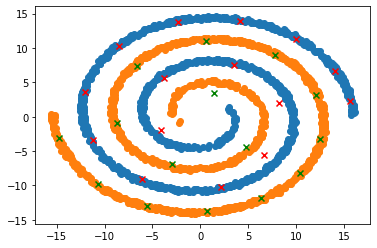

In [4]:
means0,allotments0 = k_means(train_data_classes[0,:,:])
means1,allotments1 = k_means(train_data_classes[1,:,:])
plt.scatter(train_data_classes[0,:,0],train_data_classes[0,:,1])
plt.scatter(train_data_classes[1,:,0],train_data_classes[1,:,1])
plt.scatter(means0[:,0],means0[:,1],c='r',marker='x')
plt.scatter(means1[:,0],means1[:,1],c='g',marker='x')
plt.show()

## What happens when we use other values of $k$

### Larger values of $k$

This is expected to be more accurate and closely fit the data, but will make our GMM covariance calculation step extremely lengthy.

Iterations to convergence = 23
Iterations to convergence = 22


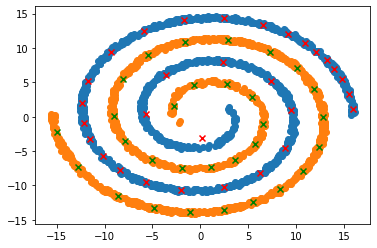

In [5]:
# larger k values:

means0,allotments0 = k_means(train_data_classes[0,:,:],30)
means1,allotments1 = k_means(train_data_classes[1,:,:],30)
plt.scatter(train_data_classes[0,:,0],train_data_classes[0,:,1])
plt.scatter(train_data_classes[1,:,0],train_data_classes[1,:,1])
plt.scatter(means0[:,0],means0[:,1],c='r',marker='x')
plt.scatter(means1[:,0],means1[:,1],c='g',marker='x')
plt.show()

As seen above, too large a value of $k$, while being extremely accurate, is not necessary as there are too many cluster centers in a very small region, which is unnecessary and will slow us down tremendously while calculating the GMM covariances.

### Smaller values of $k$

This is expected to too inaccurate to fit the data, and may actually yield worse performance than baseline (<50%) but will make our GMM covariance calculation step much faster.

Iterations to convergence = 23
Iterations to convergence = 39


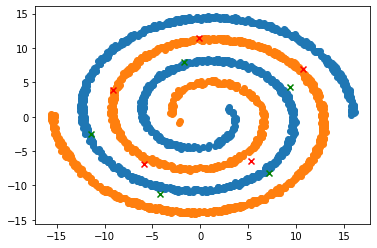

In [6]:
# smaller k values:

means0,allotments0 = k_means(train_data_classes[0,:,:],5)
means1,allotments1 = k_means(train_data_classes[1,:,:],5)
plt.scatter(train_data_classes[0,:,0],train_data_classes[0,:,1])
plt.scatter(train_data_classes[1,:,0],train_data_classes[1,:,1])
plt.scatter(means0[:,0],means0[:,1],c='r',marker='x')
plt.scatter(means1[:,0],means1[:,1],c='g',marker='x')
plt.show()

As clearly seen above, the cluster centers for too small a value of $k$ leads to the means being in the totally opposite distribution, which would actually give us worse performance than a baseline of 50%

## Expectation Maximization for Gaussian Mixtures

The $\pi_k$ matrix is initialized with values from the k-means estimate:

$$\pi_k = \frac{N_k}{N}$$

In [21]:
from scipy.stats import multivariate_normal as muno

def gaussian(x,mean,cov):
    mean = np.reshape(mean[:-1],[1,-1])
    x_mu = np.squeeze(x - mean)
    D = x_mu.shape[-1]
    covinv = np.linalg.pinv(cov)
    #print(f"x_mu {x_mu.shape}, covinv: {covinv.shape}")
    n_n = 1/(2*np.pi)**(D/2) / np.linalg.det(cov)**(1/2) * np.exp(-0.5 * x_mu @ covinv @ x_mu.T)
    return np.diagonal(n_n)

def cov(data):
    D = data.shape[-1]
    N = data.shape[0]
    # part 1: calculating means
    means = np.squeeze(np.sum(data[:,0:D],axis=0))/data.shape[0]
    # part 2: calculating covariances
    x = np.squeeze(data[:,0:D])
    covs = ((x - means).T @ (x - means))/(N-1)
    return covs

In [53]:
def EM(data,means,allotments):
    # calculate the number of points allotted to each cluster
    Nk = np.sum(allotments,axis=0)
    Nk = np.reshape(Nk,[-1,1])
    # initialize pi_k
    N = data.shape[0]
    pi_k = Nk/N
    # find D and k
    k = means.shape[0]
    D = data.shape[-1]-1
    # create x without the classes of data:
    x = data[:,0:D]
    means = means[:,0:D]
    # initialize cov_k
    cov_k = np.array([cov(x)]*k)
    # initialize log likelihood
    ll_old = np.sum(np.log(np.sum([pi_k[j] * gaussian(x,means[j],cov_k[j]) for j in range(k)])))
    while True:
        # E Step:
        deno_g = np.sum([pi_k[j] * gaussian(x,means[j],cov_k[j]) for j in range(k)],axis=0)
        gammas = np.array([pi_k[i] * gaussian(x,means[i],cov_k[i]) for i in range(k)]) / deno_g
        # M Step:
        Nk = np.sum(gammas,axis=1)
        print(f"Nk sum: {np.sum(Nk)}, Nk shape: {Nk.shape}")
        Nk = np.reshape(Nk,[-1,1])
        means = 1/Nk * gammas @ x
        cov_k = 1/np.expand_dims(Nk,2) * np.array([np.reshape(gammas[i],[1,-1]) * (x - means[i,:-1]).T@(x-means[i,:-1]) for i in range(k)])
        pi_k = Nk/N
        ll_new = np.sum(np.log(np.sum([pi_k[j] * gaussian(x,means[j],cov_k[j]) for j in range(k)])))
        print(f"ll_new: {ll_new},\nll_old: {ll_old}")
        if np.abs(ll_new - ll_old) < 1e-6:
            break
        ll_old = ll_new.copy()
    return means,cov_k

In [51]:
def EM_2(data,means,allotments):
    # calculate the number of points allotted to each cluster
    Nk = np.sum(allotments,axis=0)
    Nk = np.reshape(Nk,[-1,1])
    # initialize pi_k
    N = data.shape[0]
    pi_k = Nk/N
    # find D and k
    k = means.shape[0]
    D = data.shape[-1]-1
    # create x without the classes of data:
    x = data[:,0:D]
    means = means[:,0:D]
    # initialize cov_k
    cov_k = np.array([cov(x)]*k)
    # initialize log likelihood
    ll_old = np.sum(np.log(np.sum([pi_k[j] * muno.pdf(x,means[j],cov_k[j]) for j in range(k)])))
    while True:
        # E Step:
        deno_g = np.sum([pi_k[j] * muno.pdf(x,means[j],cov_k[j]) for j in range(k)],axis=0)
        gammas = np.array([pi_k[i] * muno.pdf(x,means[i],cov_k[i]) for i in range(k)]) / deno_g
        # M Step:
        Nk = np.sum(gammas,axis=1)
        print(f"Nk sum: {np.sum(Nk)}, Nk shape: {Nk.shape}")
        Nk = np.reshape(Nk,[-1,1])
        means = 1/Nk * gammas @ x
        means = means[:,0:D]
        cov_k = 1/np.expand_dims(Nk,2) * np.array([np.reshape(gammas[i],[1,-1]) * (x - means[i,:-1]).T@(x-means[i,:-1]) for i in range(k)])
        pi_k = Nk/N
        ll_new = np.sum(np.log(np.sum([pi_k[j] * muno.pdf(x,means[j],cov_k[j]) for j in range(k)])))
        print(f"ll_new: {ll_new},\nll_old: {ll_old}")
        if np.abs(ll_new - ll_old) < 1e-6:
            break
        ll_old = ll_new.copy()
    return means,cov_k

In [54]:
EM(train_data_classes[0,:,:],means0,allotments0)

Nk sum: 1249.9999999999998, Nk shape: (30,)
ll_new: 0.27327580231166504,
ll_old: 0.0026588989947739458
Nk sum: 1250.0000000000002, Nk shape: (30,)
ll_new: 0.2911957493519529,
ll_old: 0.27327580231166504
Nk sum: 1250.0000000000002, Nk shape: (30,)
ll_new: 0.30462252338345264,
ll_old: 0.2911957493519529
Nk sum: 1250.0, Nk shape: (30,)
ll_new: 0.31603523493584407,
ll_old: 0.30462252338345264
Nk sum: 1250.0, Nk shape: (30,)
ll_new: 0.3267004853856379,
ll_old: 0.31603523493584407
Nk sum: 1250.0, Nk shape: (30,)
ll_new: 0.3325473568135545,
ll_old: 0.3267004853856379
Nk sum: 1249.9999999999998, Nk shape: (30,)
ll_new: 0.33114007455348426,
ll_old: 0.3325473568135545
Nk sum: 1250.0, Nk shape: (30,)
ll_new: 0.3295276397634287,
ll_old: 0.33114007455348426
Nk sum: 1249.9999999999998, Nk shape: (30,)
ll_new: 0.33090902048114657,
ll_old: 0.3295276397634287
Nk sum: 1250.0000000000002, Nk shape: (30,)
ll_new: 0.3343327633872605,
ll_old: 0.33090902048114657
Nk sum: 1250.0, Nk shape: (30,)
ll_new: 0.336

KeyboardInterrupt: 

In [ ]:
EM_2(train_daxta_classes[0,:,:],means0,allotments0)

first sum: 1.0
(1250,)
Nk sum: 1250.0, Nk shape: (30,)
ll_new: 0.19766221250993518,
ll_old: -0.028239904859237663
pi_k sum: 0.9999999999999999
(1250,)
Nk sum: 1250.0, Nk shape: (30,)
ll_new: 0.24599844433235052,
ll_old: 0.19766221250993518
pi_k sum: 1.0000000000000002
(1250,)
Nk sum: 1250.0000000000002, Nk shape: (30,)
ll_new: 0.2708462348538574,
ll_old: 0.24599844433235052
pi_k sum: 0.9999999999999999
(1250,)
Nk sum: 1249.9999999999998, Nk shape: (30,)
ll_new: 0.28744730727616674,
ll_old: 0.2708462348538574
pi_k sum: 1.0
(1250,)
Nk sum: 1250.0000000000002, Nk shape: (30,)
ll_new: 0.3008865461405762,
ll_old: 0.28744730727616674
pi_k sum: 1.0000000000000002
(1250,)
Nk sum: 1249.9999999999998, Nk shape: (30,)
ll_new: 0.3130003364238437,
ll_old: 0.3008865461405762
pi_k sum: 0.9999999999999999
(1250,)
Nk sum: 1249.9999999999998, Nk shape: (30,)
ll_new: 0.3246627960566233,
ll_old: 0.3130003364238437
pi_k sum: 1.0000000000000002
(1250,)
Nk sum: 1250.0000000000002, Nk shape: (30,)
ll_new: 0.3

(array([[ -9.37080462,   3.41593104],
        [-12.3717946 ,   1.36872368],
        [  8.26722042,   3.80948215],
        [ -8.03612921,   0.41259716],
        [ -4.58526718,   4.53814856],
        [-11.47573188,   1.21627837],
        [  9.6056322 ,   1.8749236 ],
        [ -8.18263147,   1.52725035],
        [-10.22278242,   2.30273011],
        [ -8.25852706,   4.66628782],
        [ -4.91924549,   3.27824975],
        [ -9.14582727,   2.30612433],
        [-12.03561414,   1.84870357],
        [ -8.1299438 ,  10.90437697],
        [ -2.67362659,  -6.60311144],
        [ 14.75449995,   4.8515307 ],
        [  9.04101145,   0.86501564],
        [ -9.4424917 ,   3.16725949],
        [ -9.37889206,   3.39455163],
        [ -5.96485867,   1.56105076],
        [ -9.75708485,   2.63143009],
        [ -8.80657062,   2.38765739],
        [ -1.84876127,   7.09149942],
        [ -8.95471599,   3.179868  ],
        [  2.2388752 ,   5.54397399],
        [ -9.67626098,   2.72306914],
        [ -9